In [43]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [44]:
!pip install music21
!pip install pretty_midi
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import the necessary modules

import tensorflow as tf
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
import glob
import datetime
import collections
import random
import fluidsynth
import warnings

from IPython import display
import music21
import pretty_midi
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple


warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Getting the Dataset

## Using the MAESTRO Dataset

In [4]:
dir = pathlib.Path('data/maestro-v3.0.0')
if not dir.exists():
    tf.keras.utils.get_file(
        'maestro-v3.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
        extract=True,
        cache_dir='.', 
        cache_subdir='data',
    )

In [5]:
filenames = glob.glob(str(dir/'**/*.mid*'))
print(f"Number of files: {len(filenames)}")


Number of files: 1276


Music21 stream is created from each file in the above cell which contains both, chords and notes

Parse a single MIDI file and inspect the format of the notes

In [6]:
sample_file = filenames[0]
print(sample_file)

data/maestro-v3.0.0/2017/MIDI-Unprocessed_071_PIANO071_MID--AUDIO-split_07-08-17_Piano-e_1-04_wav--3.midi


Generate a `PrettyMIDI` object for sample file

In [7]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [8]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30) -> display.Audio:
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    short_wf = waveform[:seconds * _SAMPLING_RATE]

    return display.Audio(short_wf, rate=_SAMPLING_RATE)

In [9]:
# Use with music21 stream (not currently in this project)

def extract_notes(file: List[str]) -> List:
    notes = []
    pick = None
    for midi in file:
        songs = music21.instrument.partitionByInstrument(midi)
        for part in songs.parts:
            pick = part.recurse()
            for elem in pick:
                if isinstance(elem, music21.note.Note):
                    notes.append(str(elem.pitch))
                elif isinstance(elem, music21.chord.Chord):
                    notes.append(".".join(str(n) for n in elem.normalOrder))
    return notes


# Use with pretty_midi to extract notes
def extract_midi_notes(file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # sort notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda x: x.start)
    prev = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['key'].append(pretty_midi.note_number_to_name(note.pitch))
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev)
        notes['duration'].append(end - start)
        prev = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})



In [10]:
display_audio(pm)

In [11]:
# inspect instruments
print(f'Number of instruments: {len(pm.instruments)}')
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print(f'Instrument name: {instrument_name}')

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract Notes

In [12]:
for i, note in enumerate(instrument.notes[:10]):
    n_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={n_name},  duration={duration:.4f}')

0: pitch=43, note_name=G2,  duration=0.4427
1: pitch=50, note_name=D3,  duration=0.2177
2: pitch=55, note_name=G3,  duration=0.1333
3: pitch=59, note_name=B3,  duration=0.0969
4: pitch=62, note_name=D4,  duration=0.0990
5: pitch=59, note_name=B3,  duration=0.0719
6: pitch=55, note_name=G3,  duration=0.0729
7: pitch=50, note_name=D3,  duration=0.0771
8: pitch=43, note_name=G2,  duration=0.1062
9: pitch=50, note_name=D3,  duration=0.1354


In [13]:
raw_notes = extract_midi_notes(sample_file)
raw_notes.head()

,key,pitch,start,end,step,duration
0,G2,43,1.032292,1.475000,0.000000,0.442708
1,D3,50,1.420833,1.638542,0.388542,0.217708
2,G3,55,1.695833,1.829167,0.275000,0.133333
3,B3,59,1.922917,2.019792,0.227083,0.096875
4,D4,62,2.102083,2.201042,0.179167,0.098958


Visualise Music

In [14]:
def plot_piano(notes: pd.DataFrame, count: Optional[int] = None) -> None:
    if count:
        title = f' First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    
    plt.figure(figsize=(20,4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis = 0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis = 0)
    plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="darkslategrey", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)


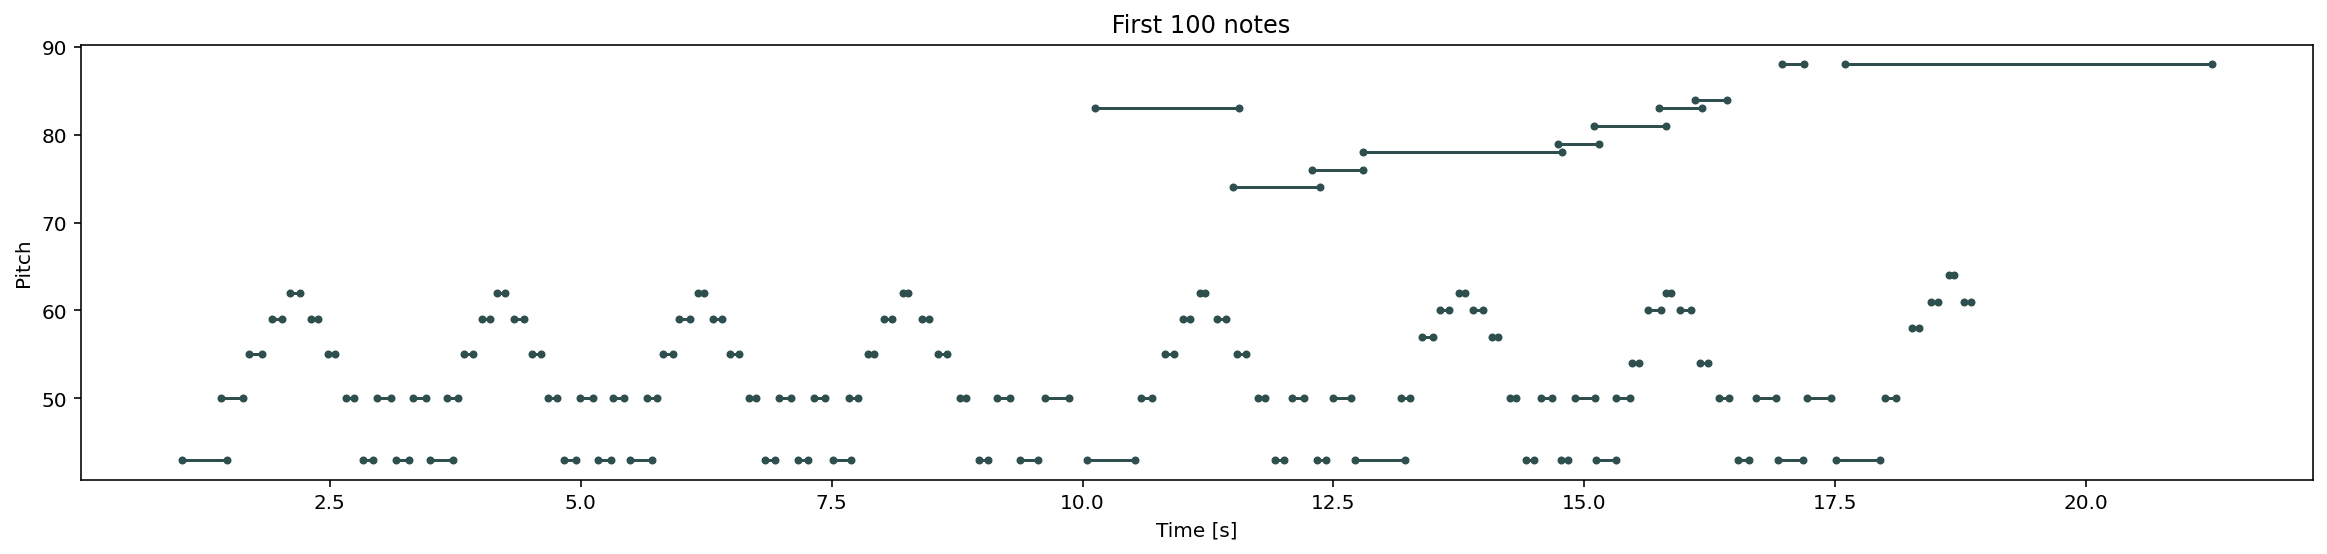

In [15]:
# initial 100 notes
plot_piano(raw_notes, count=100)

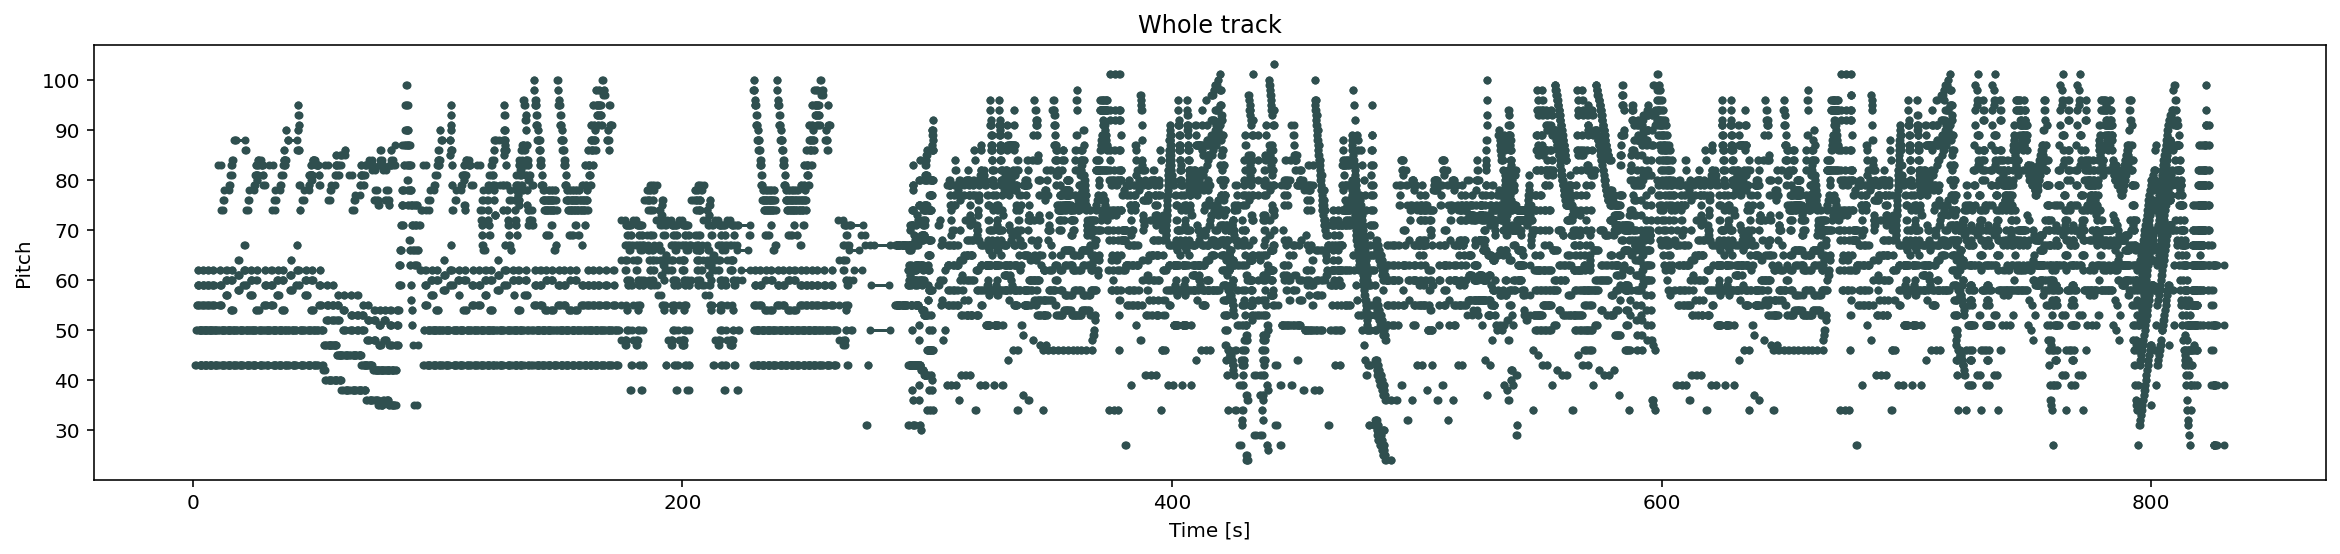

In [16]:
plot_piano(raw_notes)

Check distribution of each note variable

In [17]:
def plot_distribution(notes: pd.DataFrame, drop_percentile=2.5) -> None:
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    sns.histplot(notes, x='pitch', bins=20)

    plt.subplot(1,3,2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x='step', bins=np.linspace(0, max_step, 21))

    plt.subplot(1,3,3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x='duration', bins=np.linspace(0, max_duration, 21))

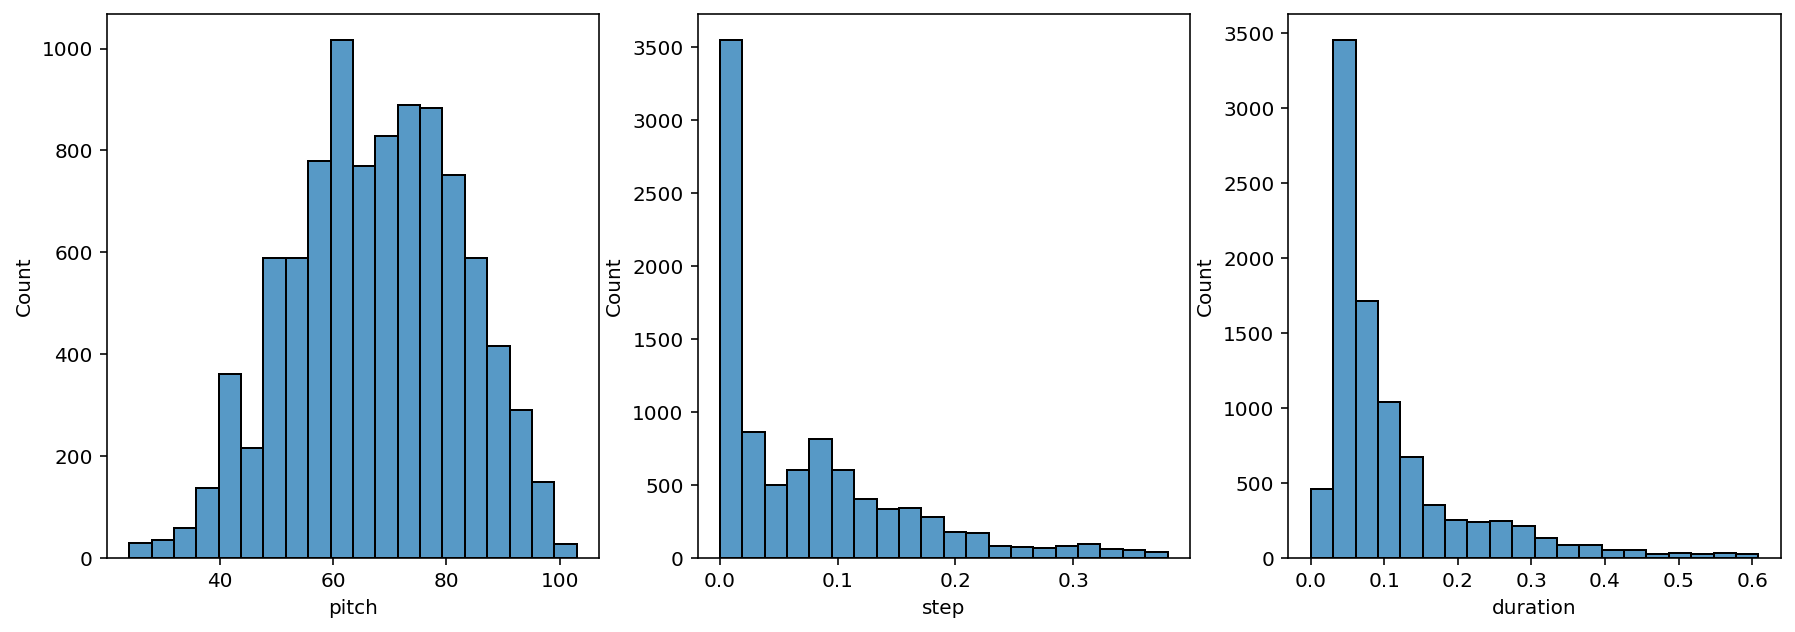

In [18]:
plot_distribution(raw_notes)

The `pitch` is the perceptual quality of the sound as a MIDI note number. The `step` is the time elapsed from the previous note or start of the track. The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.



In [19]:
# Generate MIDI file
def generate_midi(notes: pd.DataFrame, output: str, instrument_name: str, velocity: int = 100) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program= pretty_midi.instrument_name_to_program(instrument_name)
    )
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity = velocity,
            pitch = int(note['pitch']),
            start = start,
            end = end,
        )
        instrument.notes.append(note)
        prev_Start = start
    
    pm.instruments.append(instrument)
    pm.write(output)
    return pm


In [20]:
test_file = 'test.midi'
test_pm = generate_midi(raw_notes, test_file, instrument_name)

In [21]:
display_audio(test_pm)

# Does not give good output?

In [53]:
# Training Data
all_notes = list()
# using only 5 due to limited resources
for file in filenames[:5]:
    notes = extract_midi_notes(file)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [54]:
n_notes = len(all_notes)
print(f'Number of notes parsed: {n_notes}')

Number of notes parsed: 35799


In [55]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [56]:
dataset_train = tf.data.Dataset.from_tensor_slices(train_notes)
dataset_train.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [57]:
def create_seq(dataset: tf.data.Dataset, sequence_len: int, vocab_size: int = 128,) -> tf.data.Dataset:
    sequence_len += 1
    windows = dataset.window(sequence_len, shift = 1, stride = 1, drop_remainder=True)

    flatten = lambda x: x.batch(sequence_len, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    def scale_pitch(x):
        return x/[vocab_size, 1.0, 1.0]
    
    def split_label(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i, key in enumerate(key_order)}

        return scale_pitch(inputs), labels
    
    return sequences.map(split_label, num_parallel_calls=tf.data.AUTOTUNE)

In [58]:
seq_length = 32
vocab_size = 128
seq_ds = create_seq(dataset_train, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(32, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [59]:
for seq, target in seq_ds.take(1):
  print(f'sequence shape: {seq.shape}')
  print(f'sequence elements (first 10): {seq[0: 10]}')
  print()
  print(f'target: {target}')

sequence shape: (32, 3)
sequence elements (first 10): [[0.3359375  0.         0.44270833]
 [0.390625   0.38854167 0.21770833]
 [0.4296875  0.275      0.13333333]
 [0.4609375  0.22708333 0.096875  ]
 [0.484375   0.17916667 0.09895833]
 [0.4609375  0.21145833 0.071875  ]
 [0.4296875  0.16666667 0.07291667]
 [0.390625   0.18020833 0.07708333]
 [0.3359375  0.16666667 0.10625   ]
 [0.390625   0.14791667 0.13541667]]

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=43.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.16354166666666714>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.0927083333333325>}


In [60]:
batch_size = 64
buffer = n_notes - seq_length
train_ds = (seq_ds.shuffle(buffer).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [61]:
train_ds.element_spec

(TensorSpec(shape=(64, 32, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [62]:
def mse(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    mse = (y_true - y_pred)**2
    pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + pressure)

In [63]:
input_shape = (seq_length, 3)
lr = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse,
      'duration': mse,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [64]:
losses = model.evaluate(train_ds, return_dict=True)
losses

558/558 [==============================] - 20s 24ms/step - loss: 5.1954 - duration_loss: 0.1846 - pitch_loss: 4.8546 - step_loss: 0.1562


{'loss': 5.19540548324585,
 'duration_loss': 0.18459446728229523,
 'pitch_loss': 4.854624271392822,
 'step_loss': 0.15618710219860077}

In [65]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [66]:
model.evaluate(train_ds, return_dict=True)

558/558 [==============================] - 15s 24ms/step - loss: 0.5835 - duration_loss: 0.1846 - pitch_loss: 4.8546 - step_loss: 0.1562


{'loss': 0.5835124254226685,
 'duration_loss': 0.18459446728229523,
 'pitch_loss': 4.854624271392822,
 'step_loss': 0.15618710219860077}

In [67]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [68]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
558/558 [==============================] - 40s 60ms/step - loss: 0.3315 - duration_loss: 0.0996 - pitch_loss: 4.0026 - step_loss: 0.0318
Epoch 2/50
558/558 [==============================] - 33s 60ms/step - loss: 0.3207 - duration_loss: 0.0955 - pitch_loss: 3.9032 - step_loss: 0.0301
Epoch 3/50
558/558 [==============================] - 34s 62ms/step - loss: 0.3177 - duration_loss: 0.0941 - pitch_loss: 3.8802 - step_loss: 0.0295
Epoch 4/50
558/558 [==============================] - 33s 59ms/step - loss: 0.3135 - duration_loss: 0.0928 - pitch_loss: 3.8307 - step_loss: 0.0292
Epoch 5/50
558/558 [==============================] - 36s 65ms/step - loss: 0.3116 - duration_loss: 0.0921 - pitch_loss: 3.8129 - step_loss: 0.0288
Epoch 6/50
558/558 [==============================] - 33s 60ms/step - loss: 0.3095 - duration_loss: 0.0907 - pitch_loss: 3.8031 - step_loss: 0.0286
Epoch 7/50
558/558 [==============================] - 32s 57ms/step - loss: 0.3077 - duration_loss: 0.0897 - pit

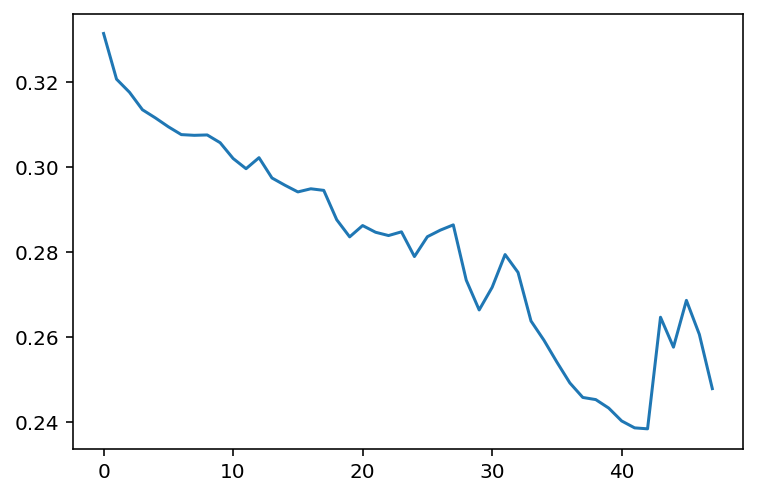

In [69]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [70]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:

    assert temperature > 0

  
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [71]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 26ms/step


In [72]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,67,0.147596,0.170948,0.147596,0.318545
1,83,0.156700,0.013635,0.304296,0.317932
2,96,0.212046,0.147939,0.516343,0.664282
3,94,0.215223,0.169529,0.731566,0.901095
4,96,0.216387,0.179813,0.947953,1.127766
5,96,0.219718,0.187588,1.167671,1.355258
6,96,0.222580,0.199400,1.390251,1.589650
7,96,0.226222,0.211881,1.616472,1.828354
8,96,0.226549,0.229356,1.843021,2.072378
9,76,0.224872,0.238199,2.067893,2.306092


In [76]:
out_file = 'output.mid'
out_pm = generate_midi(
    generated_notes, out_file, instrument_name)
display_audio(out_pm)

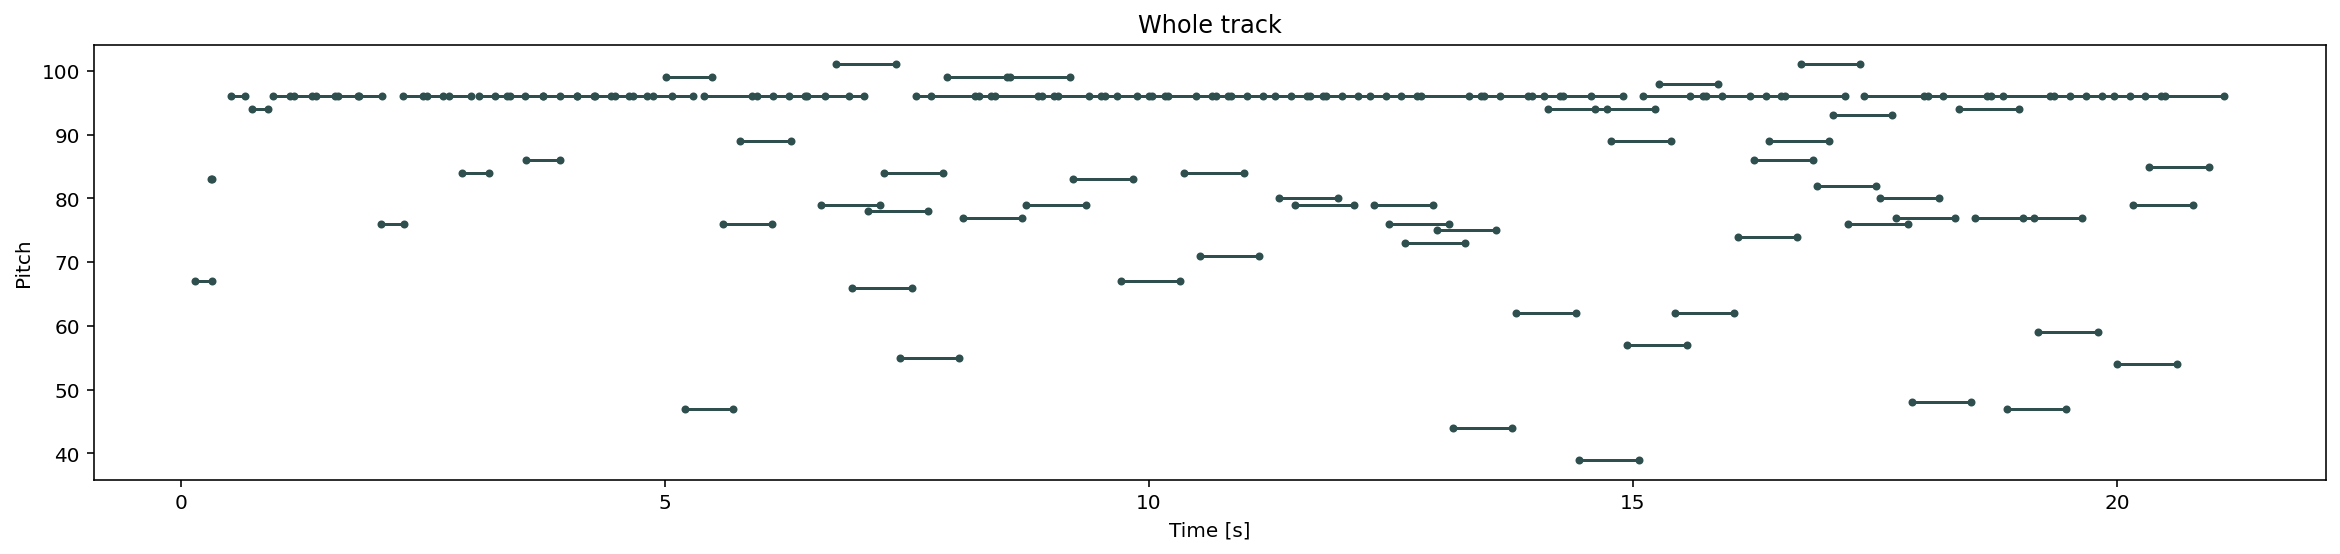

In [77]:
plot_piano(generated_notes)

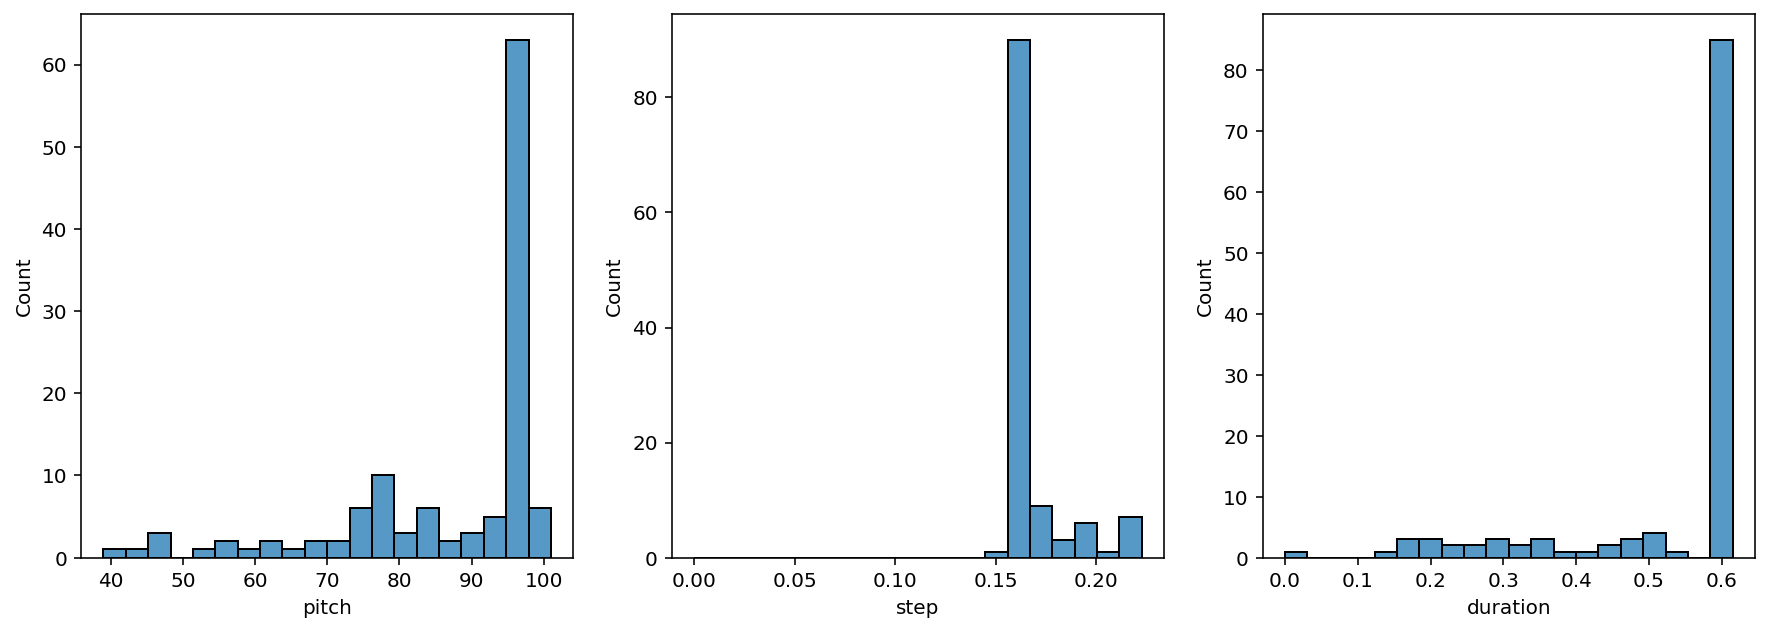

In [78]:
plot_distribution(generated_notes)